Adapted from:
<a href="https://colab.research.google.com/github/flatplanet/Pytorch-Tutorial-Youtube/blob/main/simple_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import project_functions as pf
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import csv
import plotly
#import plotly.graph_obcalled_listects as go
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import unittest
import os
from sklearn.model_selection import train_test_split



In [27]:
#First Model is based on regressed values (no other data)- retrieving our dataframe used for ML inputs and training goal
ti_ppi_df = pd.read_csv("Relevant Data/ti_ppi_df.csv")


In [28]:
# Model_1 is based on derivatives, regressed predictions, of the base time series
class Model_1(nn.Module):
  # Input layer (new index, 3 regressed values, and more associated features to predict percentage change totaled to 6) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (I want one numeric prediction)
  def __init__(self, in_features=6, h1=12, h2=10, out_features=1):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x


In [29]:
# Pick a manual seed for randomization
torch.manual_seed(37)
# Create an instance of model
model = Model_1()
my_df = ti_ppi_df
# Remove the last row as it doesn't have the associated prediction. 
my_df = my_df.iloc[:-1]


#transform my_df into a [0, 1] scaled matrix. Let's drop time and shifted close earlier so we don't have to create edge cases...
my_df = my_df.drop('time', axis=1)
my_df = my_df.drop('shifted_close', axis=1)


t_back_min, t_back_max = min(my_df['percent_change']), max(my_df['percent_change'])
#Transform back minimun and maximun



my_df_scaled = my_df
my_df_scaled['new_index'] = pf.scale01(my_df_scaled['new_index'])
my_df_scaled['close'] = pf.scale01(my_df_scaled['close'])
my_df_scaled['linear_p_x'] = pf.scale01(my_df_scaled['linear_p_x'])
my_df_scaled['quad_p_x'] = pf.scale01(my_df_scaled['quad_p_x'])
my_df_scaled['cubic_p_x'] = pf.scale01(my_df_scaled['cubic_p_x'])
my_df_scaled['net_change'] = pf.scale01(my_df_scaled['net_change'])
my_df_scaled['percent_change'] = pf.scale01(my_df_scaled['percent_change'])
    




In [30]:
# Train Test Split!  Set X, y
X = my_df_scaled
X = X.drop('percent_change', axis=1)
y = my_df_scaled['percent_change']
# Convert these to numpy arrays
X = X.values
y = y.values
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y labels to float tensors
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Set the criterion of model to measure the error, how far off the predictions are from the data - PyTorch Forum suggest MSELoss
criterion = nn.MSELoss()
# Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 200
losses = []
#set this parameter to try to resolve error

for i in range(epochs):
  # Go forward and get a prediction
    y_pred = model.forward(X_train) # Get predicted results
    y_pred = y_pred[:,0]

  # Measure the loss/error, gonna be high at first

    loss = criterion(y_pred, y_train) # predicted values vs the y_train

  # Keep Track of our losses
    losses.append(loss.detach().numpy())

  # print every 10 epoch
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

  # Do some back propagation: take the error rate of forward propagation and feed it back
  # thru the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch: 0 and loss: 0.00653353426605463
Epoch: 10 and loss: 0.003271696390584111
Epoch: 20 and loss: 0.0030276405159384012
Epoch: 30 and loss: 0.0028415017295628786
Epoch: 40 and loss: 0.0026947802398353815
Epoch: 50 and loss: 0.002524344716221094
Epoch: 60 and loss: 0.0022841847967356443
Epoch: 70 and loss: 0.0019007370574399829
Epoch: 80 and loss: 0.0012780511751770973
Epoch: 90 and loss: 0.0009681828669272363
Epoch: 100 and loss: 0.0008357574697583914
Epoch: 110 and loss: 0.0005333124427124858
Epoch: 120 and loss: 0.0004888892872259021
Epoch: 130 and loss: 0.0004401736077852547
Epoch: 140 and loss: 0.0004247333272360265
Epoch: 150 and loss: 0.0004137646174058318
Epoch: 160 and loss: 0.00040614933823235333
Epoch: 170 and loss: 0.0004006049712188542
Epoch: 180 and loss: 0.00039554215618409216
Epoch: 190 and loss: 0.00039173426921479404


Text(0.5, 0, 'Epoch')

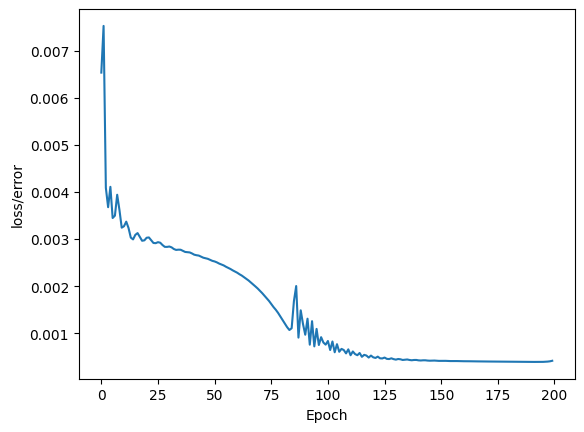

In [31]:
# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

In [32]:
# Evaluate Model on Test Data Set (validate model on test set)
with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    y_eval = y_eval[:,0]
    loss = criterion(y_eval, y_test) # Find the loss or error


Text(0, 0.5, 'Change in Percentage')

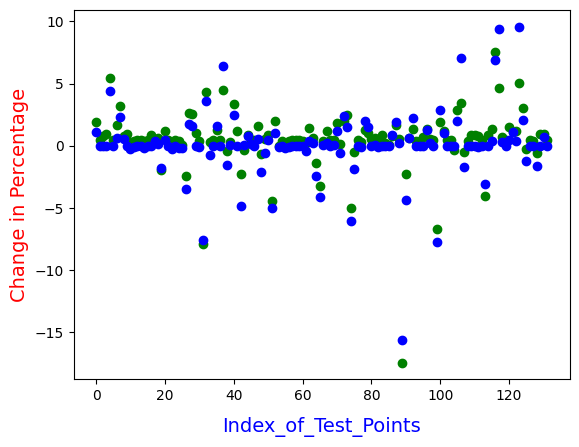

In [39]:

y_eval_t_b = pf.scale01_t_back(y_eval, t_back_min, t_back_max)
y_test_t_b = pf.scale01_t_back(y_test, t_back_min, t_back_max)

plt.scatter(range(len(y_eval_t_b)) , y_eval_t_b, c='green', label='Predicted' ) 
plt.scatter(range(len(y_test_t_b)) , y_test_t_b, c='blue', label='Actual' ) 

plt.xlabel("Index_of_Test_Points", fontsize=14, color='blue', labelpad=10)
plt.ylabel("Change in Percentage", fontsize=14, color='red', rotation=90)


We are 99% confident that our predictions are correct within +/- 357.1530456542969 basis points of the ML model output.


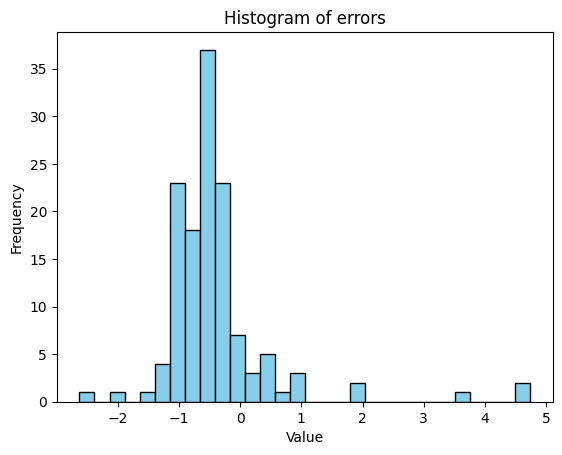

In [34]:
#Calculate uncertainties / error associated with model - Statement of confidence associated with prediction

nn_1_errors = y_test_t_b - y_eval_t_b


std_dev_nn_1 = np.std(nn_1_errors)
safety_factor = 1.5

#k-value for 99% confidence
conf_99 = 2.576

margin_of_error = conf_99 * safety_factor * std_dev_nn_1 * 100
#Multiplying it by 100 because it is originally stated in percent change as we are defining it in basis poitns

print(f"We are 99% confident that our predictions are correct within +/- {margin_of_error} basis points of the ML model output." )

plt.hist(nn_1_errors, bins=30, color='skyblue', edgecolor='black') # `bins` defines the number of intervals

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of errors')

# 4. Display the plot
plt.show()




In [36]:
# Save our NN Model
torch.save(model.state_dict(), 'M1_PPI_reg.pt')
# Load the Saved Model

saved_model = Model_1()
saved_model.load_state_dict(torch.load('M1_PPI_reg.pt', weights_only=False))
#Confirms that our saved model is indeed what we expect
saved_model.eval()


Model_1(
  (fc1): Linear(in_features=6, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
next_month_Ti_PPI_input = torch.FloatTensor(X[-1])


with torch.no_grad():  # Basically turn off back propogation
    output = saved_model.forward(next_month_Ti_PPI_input) # X_test are features from our test set, y_eval will be predictions

next_month_prediction = pf.scale01_t_back(output, t_back_min, t_back_max)
print(f"We are 99% confident that the price change from {ti_ppi_df["time"][len(ti_ppi_df["time"])-2]} to {ti_ppi_df["time"][len(ti_ppi_df["time"])-1]} is between { round((next_month_prediction[0] * 100  - margin_of_error)[0], 2) } and { round((next_month_prediction[0] * 100 + margin_of_error)[0], 2) } basis points. ")
print(f"This prediction is validated by the most recent basis point change of {ti_ppi_df["percent_change"] [len(ti_ppi_df["percent_change"]) - 2] * 100 }.")


We are 99% confident that the price change from 12/1/2025 to 1/1/2026 is between -365.8900146484375 and 348.4100036621094 basis points. 
This prediction is validated by the most recent basis point change of 29.91452991452942.
